In [54]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix

## Data Preprocessing and Cleaning

In [55]:
#The dataset containing train.csv and test.csv needs to put inside the folder "titanic" as shown below.


train_df = pd.read_csv('/content/drive/MyDrive/CS589 project/titanic/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/CS589 project/titanic/test.csv')

In [56]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Feature Engineering

In [58]:
# Names, Ticket, Cabin will not help in predicting the final outcome so we will drop this column
train_df1=train_df.drop(['Name','Ticket','Cabin', "PassengerId"], axis=1)
print(train_df1.head())
print(train_df1.isnull().sum())
#replacing the age by median
median_age_men=train_df1[train_df1['Sex']=="male"]['Age'].median()
median_age_women=train_df1[train_df1['Sex']=="female"]['Age'].median()
print(median_age_men)
print(median_age_women)
train_df1.loc[(train_df1.Age.isnull()) & (train_df1['Sex']=="female"),'Age']=median_age_women
train_df1.loc[(train_df1.Age.isnull()) & (train_df1['Sex']=="male"),'Age']=median_age_men

print(train_df1.isnull().sum())




   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
29.0
27.0
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64


In [59]:
#replacing embarked null values by mode which is "C" in this case
train_clean_df = train_df1
train_clean_df['Embarked'] = train_clean_df['Embarked'].fillna('C')

In [60]:
train_clean_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Encoding

In [61]:
#replacing male by 1 and female by 0
#replacing the categorical features by ordinal numbers to create numerical features
train_clean_numerical_df = train_clean_df
train_clean_numerical_df.Sex=train_clean_df.Sex.map({'female':0, 'male':1})
train_clean_numerical_df.Embarked=train_clean_df.Embarked.map({'S':0, 'C':1, 'Q':2,'nan':'NaN'})

In [62]:

train_clean_numerical_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0
1,1,1,0,38.0,1,0,71.2833,1
2,1,3,0,26.0,0,0,7.9250,0
3,1,1,0,35.0,1,0,53.1000,0
4,0,3,1,35.0,0,0,8.0500,0


Normalization

In [63]:
#Feature scaling -> Explain what is happening here in a text cell


train_clean_numerical_df.Age = (train_clean_numerical_df.Age-min(train_clean_numerical_df.Age))/(max(train_clean_numerical_df.Age)-min(train_clean_numerical_df.Age))
train_clean_numerical_df.Fare = (train_clean_numerical_df.Fare-min(train_clean_numerical_df.Fare))/(max(train_clean_numerical_df.Fare)-min(train_clean_numerical_df.Fare))



In [64]:
train_clean_numerical_df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,0.271174,1,0,0.014151,0
1,1,1,0,0.472229,1,0,0.139136,1
2,1,3,0,0.321438,0,0,0.015469,0
3,1,1,0,0.434531,1,0,0.103644,0
4,0,3,1,0.434531,0,0,0.015713,0


In [65]:
#Cleaning Test Data
print(test_df.isnull().sum())

test_df1=test_df.drop(['Name','Ticket','Cabin', "PassengerId"], axis=1)
print(test_df1.head())
print(test_df1.isnull().sum())
#replacing the age by median
median_age_men=test_df1[test_df1['Sex']=="male"]['Age'].median()
median_age_women=test_df1[test_df1['Sex']=="female"]['Age'].median()
print(median_age_men)
print(median_age_women)
test_df1.loc[(test_df1.Age.isnull()) & (test_df1['Sex']=="female"),'Age']=median_age_women
test_df1.loc[(test_df1.Age.isnull()) & (test_df1['Sex']=="male"),'Age']=median_age_men

print(test_df1.isnull().sum())

#removing the 1 embarked null rows in test set
test_clean_df = test_df1
test_clean_df["Embarked"] = test_clean_df['Embarked'].fillna('C')


print(test_clean_df.isnull().sum())


test_clean_numerical_df = test_clean_df
test_clean_numerical_df.Sex=test_clean_df.Sex.map({'female':0, 'male':1})
test_clean_numerical_df.Embarked=test_clean_df.Embarked.map({'S':0, 'C':1, 'Q':2,'nan':'NaN'})



#one value of fare is NaN replacing it by median
test_clean_numerical_df['Fare']  = test_clean_numerical_df['Fare'].fillna(test_clean_numerical_df['Fare'].median())

print(test_clean_numerical_df.head())
print(test_clean_numerical_df.isna().sum())



PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  34.5      0      0   7.8292        Q
1       3  female  47.0      1      0   7.0000        S
2       2    male  62.0      0      0   9.6875        Q
3       3    male  27.0      0      0   8.6625        S
4       3  female  22.0      1      1  12.2875        S
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64
27.0
27.0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64
   Pclass  Sex   Age  SibSp  Parch     Fare Embarked
0       3    1  34.5      0      0   7.

In [66]:
test_clean_numerical_df.Age = (test_clean_numerical_df.Age-min(test_clean_numerical_df.Age))/(max(test_clean_numerical_df.Age)-min(test_clean_numerical_df.Age))
test_clean_numerical_df.Fare = (test_clean_numerical_df.Fare-min(test_clean_numerical_df.Fare))/(max(test_clean_numerical_df.Fare)-min(test_clean_numerical_df.Fare))


In [67]:
#Splitting the train set into train and validation
from sklearn.model_selection import train_test_split


X_train, X_validation, y_train, y_validation = train_test_split(
    train_clean_numerical_df.drop(['Survived'], axis=1),
    train_clean_numerical_df.Survived,
    test_size= 0.2,
    random_state=0,
    stratify=train_clean_numerical_df.Survived
)



In [68]:
print(X_train)
print(y_train)


     Pclass  Sex       Age  SibSp  Parch      Fare Embarked
502       3    0  0.334004      0      0  0.014891        2
464       3    1  0.359135      0      0  0.015713        0
198       3    0  0.334004      0      0  0.015127        2
765       1    0  0.635587      1      0  0.152164        0
421       3    1  0.258608      0      0  0.015094        2
..      ...  ...       ...    ...    ...       ...      ...
131       3    1  0.246042      0      0  0.013761        0
490       3    1  0.359135      1      0  0.038972        0
528       3    1  0.484795      0      0  0.015469        0
48        3    1  0.359135      2      0  0.042315        1
80        3    1  0.271174      0      0  0.017567        0

[712 rows x 7 columns]
502    0
464    0
198    1
765    1
421    0
      ..
131    0
490    0
528    0
48     0
80     0
Name: Survived, Length: 712, dtype: int64


#Learning and tuning different models on the cleaned dataset

Fix-shape universal approximators (kernel methods)

In [69]:
#Accuracy on validation set without hyperparameter tuning (default parameters)


clf = svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_validation, y_validation)
predictions = clf.predict(X_validation)

print("Accuracy on the validation set", score)





Accuracy on the validation set 0.7988826815642458


In [70]:
#Hyperparameter Tuning using GridSearch (using GridSearchCV Sklearn)
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', "linear"]}
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3, cv = 5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.804 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.754 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.825 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.803 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [71]:
print("Printing the best parameters after grid search ", grid.best_params_)

Printing the best parameters after grid search  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


Best Model Validation set accuracy:  0.7988826815642458
Classification Report
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.65      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

Confusion Matrix
 [[98 12]
 [24 45]]


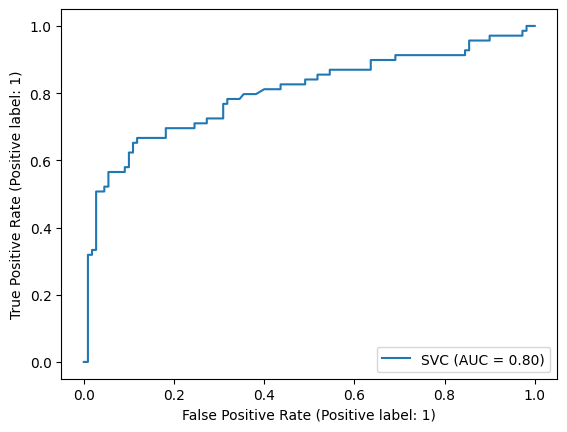

In [72]:
# Validation set accuracy after grid search on the identified best hyperparameters

from sklearn.metrics import RocCurveDisplay


svm_model_best = svm.SVC(C = 1, gamma = 0.1, kernel = "rbf")
svm_model_best.fit(X_train, y_train)
predictions = svm_model_best.predict(X_validation)
score = svm_model_best.score(X_validation, y_validation)
print("Best Model Validation set accuracy: ", score)

#Visualizing performance of best model on validation set

print("Classification Report\n", classification_report(y_validation, predictions))
print("Confusion Matrix\n", confusion_matrix(y_validation,predictions))
RocCurveDisplay.from_estimator(svm_model_best, X_validation, y_validation)


#generating submission file for kaggle
pred = svm_model_best.predict(test_clean_numerical_df)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": pred
    })
submission.to_csv('/content/drive/MyDrive/CS589 project/SVM_submission.csv', index=False)


In [73]:
test_clean_numerical_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,0.452723,0,0,0.015282,2
1,3,0,0.617566,1,0,0.013663,0
2,2,1,0.815377,0,0,0.018909,2
3,3,1,0.353818,0,0,0.016908,0
4,3,0,0.287881,1,1,0.023984,0


Neural network based universal approximators

In [74]:
#Score on validation set without hyperparameter tuning
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=50 )

clf_nn.fit(X_train, y_train)
score = clf_nn.score(X_validation, y_validation)
score


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.8100558659217877

In [75]:
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(clf_nn, parameter_space, cv=5)
grid.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2),
                                     max_iter=50, random_state=1,
                                     solver='lbfgs'),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [76]:
print("Printing the best parameters after grid search ", grid.best_params_)

Printing the best parameters after grid search  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}


Best Model Validation set accuracy:  0.7932960893854749


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

Confusion Matrix
 [[96 14]
 [23 46]]


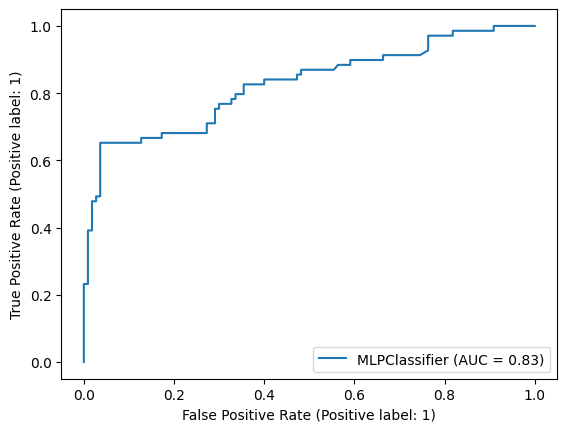

In [77]:
# Validation set accuracy after grid search on the identified best hyperparameters

NN_model_best = MLPClassifier(activation = 'relu', alpha= 0.05, hidden_layer_sizes =  (10, 30, 10), learning_rate =  'constant', solver = 'adam', max_iter = 50)
NN_model_best.fit(X_train, y_train)
score = NN_model_best.score(X_validation, y_validation)
predictions = NN_model_best.predict(X_validation)
print("Best Model Validation set accuracy: ", score)

#Visualizing performance of best model on validation set

print("Classification Report\n", classification_report(y_validation, predictions))
print("Confusion Matrix\n", confusion_matrix(y_validation,predictions))
RocCurveDisplay.from_estimator(NN_model_best, X_validation, y_validation)



#generating submission file for kaggle
pred = NN_model_best.predict(test_clean_numerical_df)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": pred
    })
submission.to_csv('/content/drive/MyDrive/CS589 project/NN_submission.csv', index=False)


Tree-based approaches

In [78]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X_train['Embarked'] = lbl.fit_transform(X_train['Embarked'].astype(str))
lbl = preprocessing.LabelEncoder()
X_validation['Embarked'] = lbl.fit_transform(X_validation['Embarked'].astype(str))



In [79]:
parameters_xg = {'max_depth':[3,6,7], 'learning_rate': [0.1,0.2], 'n_estimators': [300,200],
                 'min_child_weight': [4], 'reg_alpha': [6,0], 'reg_lambda': [1,8],'max_delta_step':[2],
                 'gamma':[0],'seed':[1]}

In [80]:
from xgboost import XGBClassifier
from sklearn import preprocessing

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
score = xgb.score(X_validation, y_validation)
print("score before hyperparameter optimization", score)


score before hyperparameter optimization 0.7988826815642458


In [81]:
# Printing the score after hyperparameter optimization and finding the best parameters

grid = GridSearchCV(xgb, parameters_xg, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0], 'learning_rate': [0.1, 0.2],
                         'max_delta_step': [2], 'max_depth': [3, 6, 7],
                         'min_child_weight': [4], 'n_estimators': [300, 200],
                         'reg_alpha': [6, 0], 'reg_lambda': [1, 8],
                         'seed': [1]})

In [82]:
print("Printing the best parameters after grid search ", grid.best_params_)

Printing the best parameters after grid search  {'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 8, 'seed': 1}


In [83]:
#finding score after hyper parameter optimization on the best hyperparameters
xgb_best = XGBClassifier(gamma = 0, learning_rate = 0.1, max_delta_step = 2, max_depth = 6, min_child_weight = 4, n_estimators= 200, reg_alpha = 0, reg_lambda = 8, seed =1)
xgb_best.fit(X_train, y_train)
score = xgb_best.score(X_validation, y_validation)
print("Score after hyperparameter optimization", score)

Score after hyperparameter optimization 0.8212290502793296


Classification Report
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

Confusion Matrix
 [[96 14]
 [23 46]]


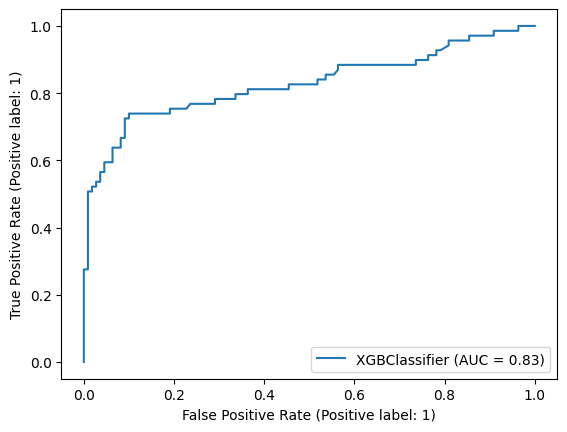

In [84]:

lbl = preprocessing.LabelEncoder()
test_clean_numerical_df['Embarked'] = lbl.fit_transform(test_clean_numerical_df['Embarked'].astype(str))
pred = xgb_best.predict(test_clean_numerical_df)

print("Classification Report\n", classification_report(y_validation, predictions))
print("Confusion Matrix\n", confusion_matrix(y_validation,predictions))

RocCurveDisplay.from_estimator(xgb_best, X_validation, y_validation)


submission_xgboost_df = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": pred
    })
submission_xgboost_df.to_csv('/content/drive/MyDrive/CS589 project/XGboost_submission.csv', index=False)
